# Evidence of chrono time by LF taders

Reproducing Figure 1.4 in High-Frequency trading EaslEy, de Prado and O’Hara.

In [1]:
%matplotlib notebook

In [2]:
#%%javascript
#IPython.OutputArea.auto_scroll_threshold = 9999;

In [3]:
import environment
import utility
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [4]:
#plt.rcParams['figure.figsize'] = [18,12]

### List of principal securities

Choose semi-random liquid-securities in NASDAQ.

In [5]:
symbols = (["AAPL","ARQL","CSCO","QQQ","FB","INTC","QCOM","NVDA","CMCSA","AMD","EEM","SPY","GDX","MSFT","AMZN"])
symbols.sort()
dates = ['01302019','12282018','05302019','05302018','03272019']

#### Function to obtain the series of total Volumes for each hour,second pair
avg over minutes (only execution volume)

In [6]:
def get_total_size(symbol,date):
    """
    read message data, extract executions, group by hour and second bukets by mean.
    So for each pair security/data return a ps.Series of mean volume happend in that Hour/Second combination.
    
    e.g. (15,38) then is the avg volume executed in all times were the hour was 15 and the seconds were 38.
    """
    a = environment.ts(date,'NASDAQ',symbol,PATH='/Volumes/LaCie/data')
    executions = a.messages.loc[a.messages.type=='E'].copy()
    new_time = executions.time.apply(lambda x: utility.parseNanosecondsToDateTime(x))
    executions.loc[:,'time'] = new_time
    executions.loc[:,'hs'] = executions.time.apply(lambda x: (x.hour,x.second))
    ts_total_size_by_sec = executions.fillna(0).groupby(['hs']).mean()
    volumes = ts_total_size_by_sec.loc[ts_total_size_by_sec.index.map(lambda x: x[0]>=9 and x[0]<=16),'size']
    return volumes/volumes.sum()

Joining all the series in a dtaframe

In [7]:
df = pd.DataFrame()
for s in symbols:
    for d in dates:
        print(s,d,sep='\t')
        try:
            serie = get_total_size(s,d)
            serie.name = s+'_'+d
            df=df.join(serie, how='outer')
        except:
            pass

AAPL	01302019
AAPL	12282018
AAPL	05302019
AAPL	05302018
AAPL	03272019
AMD	01302019


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


AMD	12282018
AMD	05302019
AMD	05302018
AMD	03272019
AMZN	01302019
AMZN	12282018
AMZN	05302019
AMZN	05302018
AMZN	03272019
ARQL	01302019
ARQL	12282018
ARQL	05302019
ARQL	05302018
ARQL	03272019
CMCSA	01302019
CMCSA	12282018
CMCSA	05302019
CMCSA	05302018
CMCSA	03272019
CSCO	01302019
CSCO	12282018
CSCO	05302019
CSCO	05302018
CSCO	03272019
EEM	01302019
EEM	12282018
EEM	05302019
EEM	05302018
EEM	03272019
FB	01302019
FB	12282018
FB	05302019
FB	05302018
FB	03272019
GDX	01302019
GDX	12282018
GDX	05302019
GDX	05302018
GDX	03272019
INTC	01302019
INTC	12282018
INTC	05302019
INTC	05302018
INTC	03272019
MSFT	01302019
MSFT	12282018
MSFT	05302019
MSFT	05302018
MSFT	03272019
NVDA	01302019
NVDA	12282018
NVDA	05302019
NVDA	05302018
NVDA	03272019
QCOM	01302019
QCOM	12282018
QCOM	05302019
QCOM	05302018
QCOM	03272019
QQQ	01302019
QQQ	12282018
QQQ	05302019
QQQ	05302018
QQQ	03272019
SPY	01302019
SPY	12282018
SPY	05302019
SPY	05302018
SPY	03272019


Normalizing the data since we want to give same weight to a stock very traded (large number size) and one that is not very traded

In [8]:
normalized_df = (df-df.min())/(df.max()-df.min())
orig_cols = normalized_df.columns
normalized_df.loc[:,'hour'] = normalized_df.index.map(lambda x: x[0])
normalized_df.loc[:,'sec'] = normalized_df.index.map(lambda x: x[1])

Building the matrix with n=0,...,59 (seconds) rows and m=9,...,16 columns (hours). 

In [9]:
n=len(set(normalized_df.sec.values))
m=len(set(normalized_df.hour.values))
B = np.zeros([n,m])
for i in range(n):
    for j in range(m):
        ans = normalized_df.loc[(normalized_df.hour==j+9) & (normalized_df.sec==i)].loc[:,orig_cols].fillna(0).mean(axis=1).values
        if ans.size>0:    
            B[i,j] = ans

A = B/np.sum(B,axis=0)/m
            
vol_df = pd.DataFrame(data=A*100,index = range(n), columns = range(9,9+m))

<IPython.core.display.Javascript object>


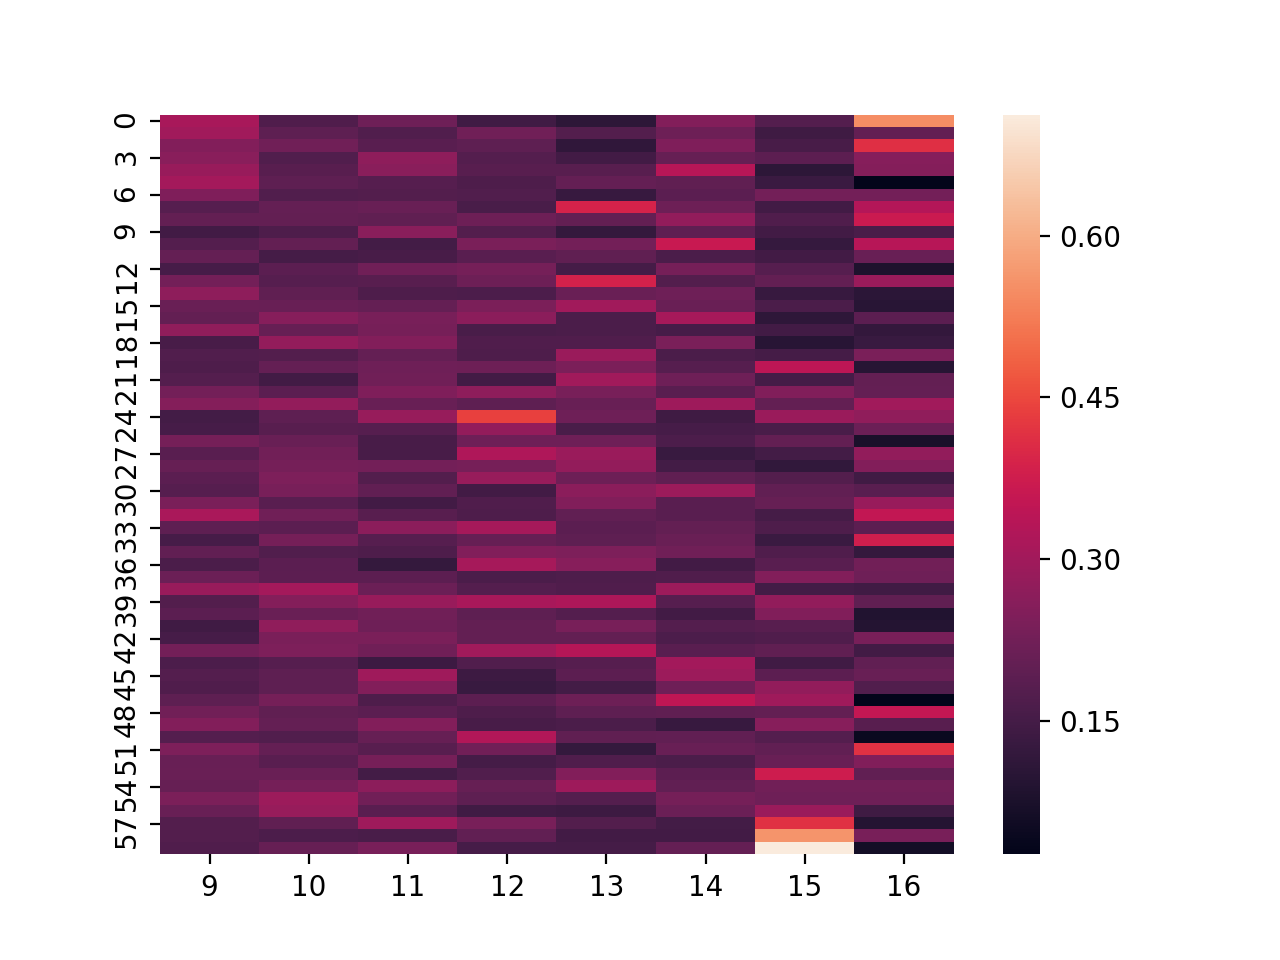

In [21]:
sns.heatmap(vol_df)
plt.show()

<IPython.core.display.Javascript object>


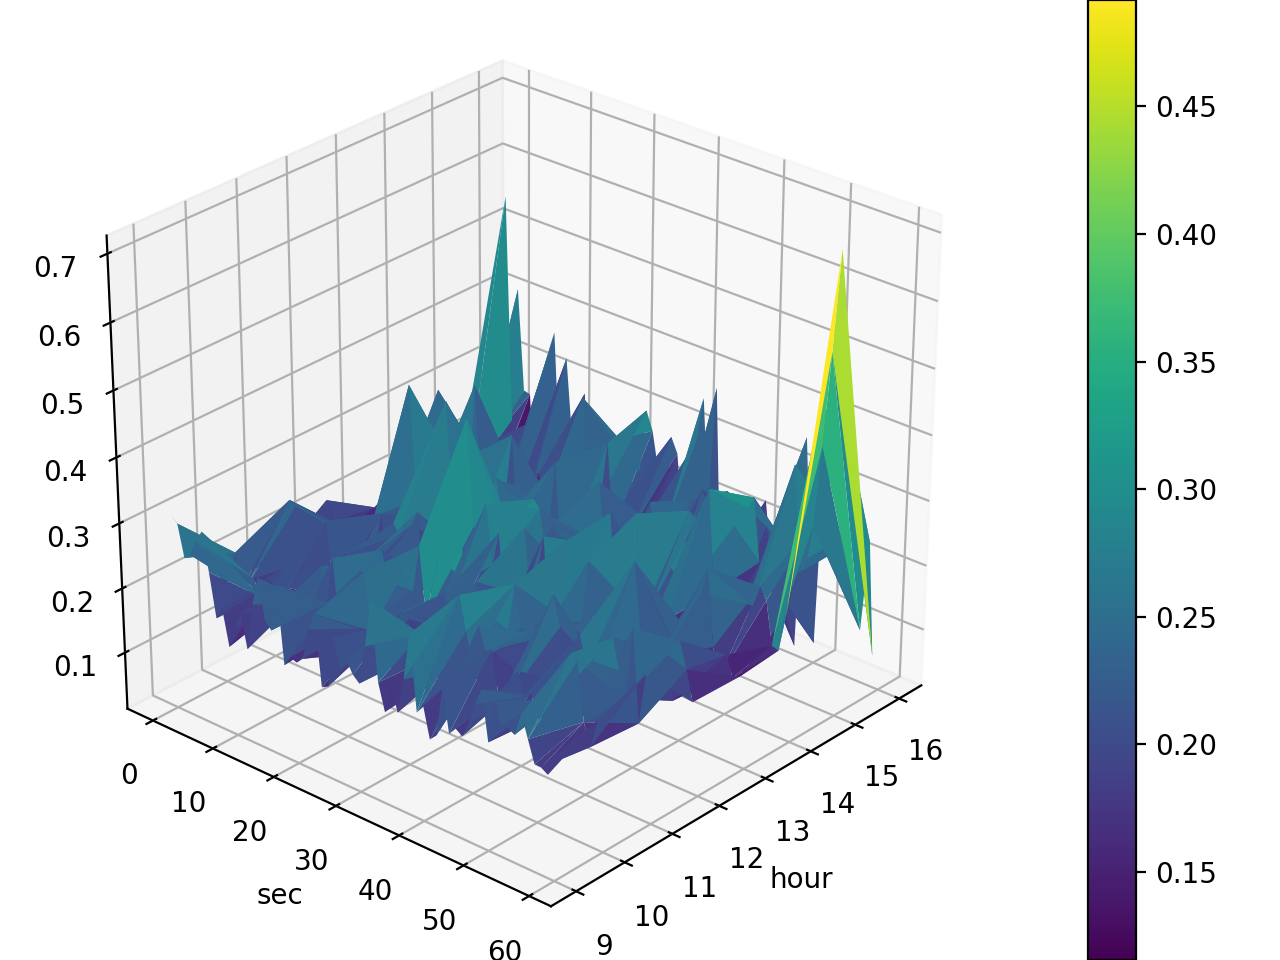

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
#ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.7, 1, 0.7, 1]))
X = vol_df.columns
Y = vol_df.index
X, Y = np.meshgrid(X, Y)
x = X.reshape(np.size(X))
y = Y.reshape(np.size(Y))
z = vol_df.values.reshape(np.size(vol_df))
f = ax.plot_trisurf(x, y, z, linewidth=0.2, cmap='viridis')
plt.xlabel('hour')
plt.ylabel('sec')
plt.colorbar(f)
ax.invert_yaxis()
plt.show()